# LiH Molecule: Constructing Potential Energy Surfaces Using VQE

## Step 1: Classical calculations

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from utility import *
import tequila as tq
threshold = 1e-6 #Cutoff for UCC MP2 amplitudes and QCC ranking gradients

basis = 'sto-3g'

#### Classical Electronic Structure Methods

In [2]:
bond_lengths = np.linspace(0.7,3.0,15)
#Run FCI
FCI_PES = obtain_PES('lih', bond_lengths, basis, method='fci')
#Run HF
HF_PES = obtain_PES('lih', bond_lengths, basis,  method='hf')
#Run CCSD
CCSD_PES = obtain_PES('lih', bond_lengths, basis,  method='ccsd')

E = -7.505051767361807 Eh
E = -7.695307186216192 Eh
E = -7.797940480712805 Eh
E = -7.850886904225847 Eh
E = -7.875225404322417 Eh
E = -7.882644441701508 Eh
E = -7.879987227897543 Eh
E = -7.871519789475591 Eh
E = -7.860019217763555 Eh
E = -7.8473500000766085 Eh
E = -7.834797280603318 Eh
E = -7.823251672203907 Eh
E = -7.81328379544711 Eh
E = -7.805155556416904 Eh
E = -7.798843159455239 Eh
E = -7.4860204040661715 Eh
E = -7.677464259854675 Eh
E = -7.781036385083806 Eh
E = -7.8341635331748005 Eh
E = -7.8577487033244715 Eh
E = -7.863443533207834 Eh
E = -7.85807009427633 Eh
E = -7.845844464700195 Eh
E = -7.829457815381848 Eh
E = -7.810658539946649 Eh
E = -7.790604683358963 Eh
E = -7.770091643682429 Eh
E = -7.7496981251691475 Eh
E = -7.729870178602056 Eh
E = -7.710958961728265 Eh
E = -7.505041804061137 Eh
E = -7.695300845290883 Eh
E = -7.79793389680691 Eh
E = -7.85087954961508 Eh
E = -7.875216475211244 Eh
E = -7.882633296257904 Eh
E = -7.879973728010883 Eh
E = -7.871503905176357 Eh
E = -7.8600

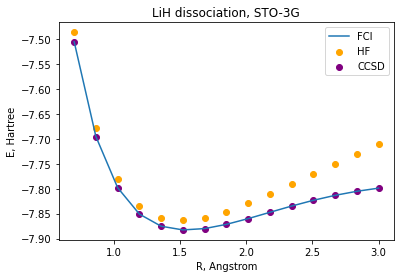

In [3]:
#Plot LiH PESs

plt.title('LiH dissociation, STO-3G')
plt.xlabel('R, Angstrom')
plt.ylabel('E, Hartree')

plt.plot(bond_lengths, FCI_PES, label='FCI')
plt.scatter(bond_lengths, HF_PES, label='HF', color='orange')
plt.scatter(bond_lengths, CCSD_PES, label='CCSD', color='purple')
plt.legend()

## Step 2: Generating Qubit Hamiltonians

In [4]:
qubit_transf = 'jw' # Jordan-Wigner transformations
lih = get_qubit_hamiltonian(mol='lih', geometry=1, basis='sto3g', qubit_transf=qubit_transf)
print(lih)

-3.9344419567578965 [] +
-0.007923321157850875 [X0 X1 Y2 Y3] +
-0.003414532358015549 [X0 X1 Y2 Z3 Z4 Y5] +
-0.0027468613203171523 [X0 X1 Y2 Z3 Z4 Z5 Z6 Z7 Z8 Z9 Z10 Y11] +
-0.00341453235801555 [X0 X1 X3 X4] +
-0.0027468613203171523 [X0 X1 X3 Z4 Z5 Z6 Z7 Z8 Z9 X10] +
-0.004864778381760612 [X0 X1 Y4 Y5] +
-0.002296316587299247 [X0 X1 Y4 Z5 Z6 Z7 Z8 Z9 Z10 Y11] +
-0.002296316587299247 [X0 X1 X5 Z6 Z7 Z8 Z9 X10] +
-0.0024727061683852756 [X0 X1 Y6 Y7] +
-0.0024727061683852765 [X0 X1 Y8 Y9] +
-0.0017744350099502088 [X0 X1 Y10 Y11] +
0.007923321157850875 [X0 Y1 Y2 X3] +
0.003414532358015549 [X0 Y1 Y2 Z3 Z4 X5] +
0.0027468613203171523 [X0 Y1 Y2 Z3 Z4 Z5 Z6 Z7 Z8 Z9 Z10 X11] +
-0.00341453235801555 [X0 Y1 Y3 X4] +
-0.0027468613203171523 [X0 Y1 Y3 Z4 Z5 Z6 Z7 Z8 Z9 X10] +
0.004864778381760612 [X0 Y1 Y4 X5] +
0.002296316587299247 [X0 Y1 Y4 Z5 Z6 Z7 Z8 Z9 Z10 X11] +
-0.002296316587299247 [X0 Y1 Y5 Z6 Z7 Z8 Z9 X10] +
0.0024727061683852756 [X0 Y1 Y6 X7] +
0.0024727061683852765 [X0 Y1 Y8 X9] +
0.00177

In [5]:
lih_tapered = taper_hamiltonian(lih, n_spin_orbitals=12, n_electrons=4, qubit_transf=qubit_transf)
print("Effective Hamiltonian:", lih_tapered)

## Step 3: Unitary Ansatz

In [9]:
trotter_steps = 1

xyz_data = get_molecular_data('lih', geometry=1.5, xyz_format=True)
basis='sto-3g'

lih_tq = tq.quantumchemistry.Molecule(geometry=xyz_data, basis_set=basis)

print('Number of spin-orbitals (qubits): {} \n'.format(2*lih_tq.n_orbitals))

E_FCI = lih_tq.compute_energy(method='fci')

print('FCI energy: {}'.format(E_FCI))

hf_reference = hf_occ(2*lih_tq.n_orbitals, lih_tq.n_electrons)

Number of spin-orbitals (qubits): 12 

FCI energy: -7.882362286810973


In [10]:
H = lih_tq.make_hamiltonian()

print("\nHamiltonian has {} terms\n".format(len(H)))

U_UCCSD = lih_tq.make_uccsd_ansatz(initial_amplitudes='MP2',threshold=threshold, trotter_steps=trotter_steps)

E = tq.ExpectationValue(H=H, U=U_UCCSD)

print('\nNumber of UCCSD amplitudes: {} \n'.format(len(E.extract_variables())))

print('\nStarting optimization:\n')

result = tq.minimize(objective=E, method="BFGS", initial_values={k:0.0 for k in E.extract_variables()}, tol=1e-6)

print('\nObtained UCCSD energy: {}'.format(result.energy))


Hamiltonian has 631 terms


Number of UCCSD amplitudes: 24 


Starting optimization:

Optimizer: <class 'tequila.optimizers.optimizer_scipy.OptimizerSciPy'> 
backend         : qulacs
samples         : None
save_history    : True
noise           : None

Method          : BFGS
Objective       : 1 expectationvalues
gradient        : 1024 expectationvalues

active variables : 24

E=-7.86335762  angles= {(2, 1, 5, 0): 0.0, (5, 1, 2, 1): 0.0, (5, 0, 2, 0): 0.0, (2, 0, 2, 0): 0.0, (5, 0, 5, 0): 0.0, (4, 0, 4, 1): 0.0, (2, 1, 2, 1): 0.0, (2, 0, 5, 0): 0.0, (3, 1, 3, 1): 0.0, (4, 1, 4, 0): 0.0, (5, 1, 2, 0): 0.0, (3, 0, 3, 1): 0.0, (5, 0, 2, 1): 0.0, (5, 1, 5, 0): 0.0, (4, 0, 4, 0): 0.0, (2, 0, 5, 1): 0.0, (4, 1, 4, 1): 0.0, (2, 1, 5, 1): 0.0, (3, 0, 3, 0): 0.0, (5, 1, 5, 1): 0.0, (2, 0, 2, 1): 0.0, (5, 0, 5, 1): 0.0, (2, 1, 2, 0): 0.0, (3, 1, 3, 0): 0.0}  samples= None
E=-7.83705489  angles= {(2, 1, 5, 0): -0.01038360595703125, (5, 1, 2, 1): -0.06699275970458984, (5, 0, 2, 0): -0.002532958984

E=-7.88182527  angles= {(2, 1, 5, 0): -0.0004967732328186928, (5, 1, 2, 1): -0.045755012330451116, (5, 0, 2, 0): 4.2654789718653876e-05, (2, 0, 2, 0): -0.0019048864028800724, (5, 0, 5, 0): -0.00014817945737996812, (4, 0, 4, 1): 0.003733801720023855, (2, 1, 2, 1): -0.025250935130718792, (2, 0, 5, 0): 4.265478971865301e-05, (3, 1, 3, 1): -0.026307153513362568, (4, 1, 4, 0): 0.00373380935856678, (5, 1, 2, 0): -0.00016280967738484996, (3, 0, 3, 1): 0.003734030375724647, (5, 0, 2, 1): -0.0004968113897911711, (5, 1, 5, 0): -0.0005261738554227269, (4, 0, 4, 0): -0.004746726517637291, (2, 0, 5, 1): -0.00016273301947008473, (4, 1, 4, 1): -0.026319936948476636, (2, 1, 5, 1): -0.045755111410313826, (3, 0, 3, 0): -0.0047474779730212885, (5, 1, 5, 1): -0.10986223601244043, (2, 0, 2, 1): -0.0004372290744825482, (5, 0, 5, 1): -0.0005262372952333598, (2, 1, 2, 0): -0.00043703901709549675, (3, 1, 3, 0): 0.003733931624676332}  samples= None
E=-7.88191866  angles= {(2, 1, 5, 0): -0.0004406937423353197, (

E=-7.88196452  angles= {(2, 1, 5, 0): -0.00043565881728900547, (5, 1, 2, 1): -0.04799956737445765, (5, 0, 2, 0): -6.459183063215005e-05, (2, 0, 2, 0): -0.003949225595995309, (5, 0, 5, 0): -0.0008454402576157279, (4, 0, 4, 1): 0.0029529891960904087, (2, 1, 2, 1): -0.023743940466098342, (2, 0, 5, 0): -6.403312080128402e-05, (3, 1, 3, 1): -0.027455917891455198, (4, 1, 4, 0): 0.0029533995449304204, (5, 1, 2, 0): -3.8996272598731075e-05, (3, 0, 3, 1): 0.002952874958915814, (5, 0, 2, 1): -0.0004358449972259242, (5, 1, 5, 0): 0.00033227271818906366, (4, 0, 4, 0): -0.0018031118547274007, (2, 0, 5, 1): -3.85305307999839e-05, (4, 1, 4, 1): -0.027465819249001114, (2, 1, 5, 1): -0.047999777542702966, (3, 0, 3, 0): -0.0018118365772876253, (5, 1, 5, 1): -0.10944382454040173, (2, 0, 2, 1): -2.339457687212287e-05, (5, 0, 5, 1): 0.00033249431478962386, (2, 1, 2, 0): -2.2306027784663648e-05, (3, 1, 3, 0): 0.0029525124528882165}  samples= None
E=-7.88196452  angles= {(2, 1, 5, 0): -0.00041781502674308234

## Step 4: Measurement

In [12]:
comm_groups = get_commuting_group(lih)
print('Number of mutually commuting fragments: {}'.format(len(comm_groups)))
print('The first commuting group')
print(comm_groups[1])

Number of mutually commuting fragments: 36
The first commuting group
-3.9344419567578965 [] +
0.007923321157850875 [X0 Y1 Y2 X3] +
-0.00015507836015055885 [X0 Z1 Z2 X3 Y4 Y5] +
-0.00207788690266238 [X0 Z1 Z2 X3 Y6 Y7] +
-0.0020778869026623803 [X0 Z1 Z2 X3 Y8 Y9] +
-0.002102865907376202 [X0 Z1 Z2 X3 Y10 Y11] +
0.007923321157850875 [Y0 X1 X2 Y3] +
-0.00015507836015055885 [Y0 Z1 Z2 Y3 X4 X5] +
-0.00207788690266238 [Y0 Z1 Z2 Y3 X6 X7] +
-0.0020778869026623803 [Y0 Z1 Z2 Y3 X8 X9] +
-0.002102865907376202 [Y0 Z1 Z2 Y3 X10 X11] +
0.11709373561826511 [Z0 Z3] +
-0.00015507836015055883 [X1 X2 X4 X5] +
-0.00207788690266238 [X1 X2 X6 X7] +
-0.0020778869026623803 [X1 X2 X8 X9] +
-0.002102865907376202 [X1 X2 X10 X11] +
-0.00015507836015055883 [Y1 Y2 Y4 Y5] +
-0.00207788690266238 [Y1 Y2 Y6 Y7] +
-0.0020778869026623803 [Y1 Y2 Y8 Y9] +
-0.002102865907376202 [Y1 Y2 Y10 Y11] +
0.11709373561826511 [Z1 Z2] +
-0.010590593747757613 [X4 X5 Y6 Y7] +
-0.010590593747757617 [X4 X5 Y8 Y9] +
-0.0067330307808817135 [

In [ ]:
uqwc = get_qwc_unitary(comm_groups[1])
print('This is unitary, U * U^+ = I ')
print(uqwc * uqwc)

In [14]:
qwc = remove_complex(uqwc * comm_groups[1] * uqwc)
print(qwc)

KeyboardInterrupt: 

In [ ]:
uz = get_zform_unitary(qwc)
print("Checking whether U * U^+ is identity: {}".format(uz * uz))

allz = remove_complex(uz * qwc * uz)
print("\nThe all-z form of qwc fragment:\n{}".format(allz))

## Step 5: Circuits

In [15]:
#Define number of entanglers to enter ansatz
n_ents = 1

#Rank entanglers using energy gradient criterion
ranked_entangler_groupings = generate_QCC_gradient_groupings(H.to_openfermion(), 
                                                             2*lih_tq.n_orbitals, 
                                                             hf_reference, 
                                                             cutoff=threshold)

print('Grouping gradient magnitudes (Grouping : Gradient magnitude):')
for i in range(len(ranked_entangler_groupings)):
    print('{} : {}'.format(i+1,ranked_entangler_groupings[i][1]))


entanglers = get_QCC_entanglers(ranked_entangler_groupings, n_ents, 2*lih_tq.n_orbitals)

print('\nSelected entanglers:')
for ent in entanglers:
    print(ent)

Grouping gradient magnitudes (Grouping : Gradient magnitude):
1 : 0.123
2 : 0.0335
3 : 0.0335
4 : 0.024
5 : 0.024
6 : 0.0215
7 : 0.0121
8 : 0.0098
9 : 0.0098
10 : 0.0076
11 : 0.0076
12 : 0.0076
13 : 0.0076
14 : 0.0072
15 : 0.002
16 : 0.002
17 : 0.0013
18 : 0.0013
19 : 0.0012
20 : 0.0012
21 : 0.0007
22 : 0.0007
23 : 0.0004
24 : 0.0004
25 : 0.0002
26 : 0.0002
27 : 0.0
28 : 0.0
29 : 0.0
30 : 0.0
31 : 0.0
32 : 0.0

Selected entanglers:
1.0 [X2 Y3 X10 X11]


In [16]:
#Mean-field part of U (Omega):    
U_MF = construct_QMF_ansatz(n_qubits = 2*lih_tq.n_orbitals)
#Entangling part of U:
U_ENT = construct_QCC_ansatz(entanglers)

U_QCC = U_MF + U_ENT

E = tq.ExpectationValue(H=H, U=U_QCC)

initial_vals = init_qcc_params(hf_reference, E.extract_variables())

#Minimize wrt the entangler amplitude and MF angles:
result = tq.minimize(objective=E, method="BFGS", initial_values=initial_vals, tol=1.e-6)

print('\nObtained QCC energy ({} entanglers): {}'.format(len(entanglers), result.energy))

Optimizer: <class 'tequila.optimizers.optimizer_scipy.OptimizerSciPy'> 
backend         : qulacs
samples         : None
save_history    : True
noise           : None

Method          : BFGS
Objective       : 1 expectationvalues
gradient        : 50 expectationvalues

active variables : 25

E=-6.25839976  angles= {beta_0: 3.141592653589793, gamma_0: 0.0, beta_1: 3.141592653589793, gamma_1: 0.0, beta_2: 3.141592653589793, gamma_2: 0.0, beta_3: 3.141592653589793, gamma_3: 0.0, beta_4: 0.0, gamma_4: 0.0, beta_5: 0.0, gamma_5: 0.0, beta_6: 0.0, gamma_6: 0.0, beta_7: 0.0, gamma_7: 0.0, beta_8: 0.0, gamma_8: 0.0, beta_9: 0.0, gamma_9: 0.0, beta_10: 3.141592653589793, gamma_10: 0.0, beta_11: 3.141592653589793, gamma_11: 0.0, tau_0: 0.0}  samples= None
Optimization terminated successfully.
         Current function value: -6.258400
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1

Obtained QCC energy (1 entanglers): -6.258399755644748


In [20]:
H = tq.QubitHamiltonian.from_openfermion(get_qubit_hamiltonian('lih', 1.5, 'sto-3g', qubit_transf='jw'))

a = tq.Variable("tau_0")
U = construct_QMF_ansatz(8)
U += tq.gates.ExpPauli(paulistring=tq.PauliString.from_string("X(2)Y(3)X(10)X(11)"), angle=a)
print(U)


circuit: 
Rx(target=(0,), parameter=beta_0)
Rz(target=(0,), parameter=gamma_0)
Rx(target=(1,), parameter=beta_1)
Rz(target=(1,), parameter=gamma_1)
Rx(target=(2,), parameter=beta_2)
Rz(target=(2,), parameter=gamma_2)
Rx(target=(3,), parameter=beta_3)
Rz(target=(3,), parameter=gamma_3)
Rx(target=(4,), parameter=beta_4)
Rz(target=(4,), parameter=gamma_4)
Rx(target=(5,), parameter=beta_5)
Rz(target=(5,), parameter=gamma_5)
Rx(target=(6,), parameter=beta_6)
Rz(target=(6,), parameter=gamma_6)
Rx(target=(7,), parameter=beta_7)
Rz(target=(7,), parameter=gamma_7)
Exp-Pauli(target=(2, 3, 10, 11), control=(), parameter=tau_0, paulistring=X(2)Y(3)X(10)X(11))



In [21]:
E = tq.ExpectationValue(H=H, U=U)
vars = {'beta_0': 3.141592653589793, 'gamma_0': 0.0, 'beta_1': 3.141592653589793, 'gamma_1': 0.0, 'beta_2': 3.141592653589793, 'gamma_2': 0.0, 'beta_3': 3.141592653589793, 'gamma_3': 0.0, 'beta_4': 0.0, 'gamma_4': 0.0, 'beta_5': 0.0, 'gamma_5': 0.0, 'beta_6': 0.0, 'gamma_6': 0.0, 'beta_7': 0.0, 'gamma_7': 0.0, 'beta_8': 0.0, 'gamma_8': 0.0, 'beta_9': 0.0, 'gamma_9': 0.0, 'beta_10': 3.141592653589793, 'gamma_10': 0.0, 'beta_11': 3.141592653589793, 'gamma_11': 0.0, 'tau_0': 0.0} # values obtained from step 3
print(tq.simulate(E, variables=vars))

-7.863357621535121


In [27]:
from qiskit import IBMQ
IBMQ.save_account('6f1ae0f74f3b670c62a6a7427dc22eb12f9d6eaa47e5d264218990c42e2593d029d53a92ee9260ce05f0daf11d87a8b1a1114637c90ae648bfabeddca94ae087', overwrite=True)
IBMQ.enable_account('6f1ae0f74f3b670c62a6a7427dc22eb12f9d6eaa47e5d264218990c42e2593d029d53a92ee9260ce05f0daf11d87a8b1a1114637c90ae648bfabeddca94ae087')

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [28]:
# list of devices available can be found in ibmq account page
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
device = provider.get_backend('ibmq_qasm_simulator')
tq.simulate(E, variables=vars, samples=100, backend="qiskit", device=device)#,qiskit_provider = provider) 

KeyboardInterrupt: 

In [29]:
#draw
circ = tq.circuit.compiler.compile_exponential_pauli_gate(U)
tq.draw(circ, backend="qiskit")

      ┌────────────────────┐┌─────────────────────┐                            »
q_0: ─┤ RX(f((beta_0,))_0) ├┤ RZ(f((gamma_0,))_1) ├────────────────────────────»
      ├────────────────────┤├─────────────────────┤                            »
q_1: ─┤ RX(f((beta_1,))_2) ├┤ RZ(f((gamma_1,))_3) ├────────────────────────────»
      ├────────────────────┤├─────────────────────┤    ┌───┐                   »
q_2: ─┤ RX(f((beta_2,))_4) ├┤ RZ(f((gamma_2,))_5) ├────┤ H ├──────■────────────»
      ├────────────────────┤├─────────────────────┤ ┌──┴───┴───┐┌─┴─┐          »
q_3: ─┤ RX(f((beta_3,))_6) ├┤ RZ(f((gamma_3,))_7) ├─┤ RX(pi/2) ├┤ X ├──■───────»
      ├────────────────────┤├─────────────────────┤ └──────────┘└───┘  │       »
q_4: ─┤ RX(f((beta_4,))_8) ├┤ RZ(f((gamma_4,))_9) ├────────────────────┼───────»
     ┌┴────────────────────┤├─────────────────────┴┐                   │       »
q_5: ┤ RX(f((beta_5,))_10) ├┤ RZ(f((gamma_5,))_11) ├───────────────────┼───────»
     ├─────────────────────┤